# **Graph Analytics: Project**

----------------------------------------------


#### 2021/2022
#### Lorenzo Pigozzi

<a class="anchor" id="0.1"></a>
## **Table of Contents**

1.	[Introduction](#1)
   - 1.1 [Import packages](#1.1)
   - 1.2 [Import data](#1.2)        
2.	[Exploratory Data Analysis](#2) 
3.	[Data Engineering](#3)
   - 3.1 [Weight calculation](#3.1)
   - 3.2 [Source and target creation](#3.2)   
4. [Graph Analytics](#4)
   - 4.1 [Variant Explorer](#4.1)

# **1. Introduction** <a class="anchor" id="1"></a>

### **1.1. Import packages** <a class="anchor" id="1.1"></a>

In [1]:
# general libraries
import pandas as pd
import numpy as np 
import networkx as nx
import itertools
import collections
import random
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# network related libraries
import pm4py
import pycelonis
import networkx as nx

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## **1.2. Import data** <a class="anchor" id="1.2"></a>

In [2]:
# importing the datasets
brazil = pd.read_csv('ACTIVITY_TABLE_BR.csv')
# germany = pd.read_csv('ACTIVITY_TABLE_DE.csv')
# portugal = pd.read_csv('ACTIVITY_TABLE_PT.csv')
# thailand = pd.read_csv('ACTIVITY_TABLE_TH.csv')

In [3]:
# considering just one country
df = brazil.copy()

# # merging the dataframes of the different countries
# df = pd.concat([brazil, germany, portugal, thailand], axis=0)

# **2. Exploratory Data Analysis (EDA)** <a class="anchor" id="2"></a>

In [4]:
df.head()

,ACTIVITY,TIMESTAMP,SALES_DOC,SALES_DOC_ITEM,COUNTRY
0,Create Sales Order,2021-10-04 16:22:36,50043243,10,BR
1,Create Sales Order Item,2021-10-04 16:22:36,50043243,10,BR
2,Material Availability Date passed,2021-10-04 00:00:00,50043243,10,BR
3,Create Sales Order,2021-10-04 16:22:36,50043243,20,BR
4,Create Sales Order Item,2021-10-04 16:22:36,50043243,20,BR


In [5]:
df.shape

(1837252, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837252 entries, 0 to 1837251
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   ACTIVITY        object
 1   TIMESTAMP       object
 2   SALES_DOC       int64 
 3   SALES_DOC_ITEM  int64 
 4   COUNTRY         object
dtypes: int64(2), object(3)
memory usage: 70.1+ MB


In [7]:
# changing data type for SO number and Item number
df['SALES_DOC'] = df['SALES_DOC'].astype(str)
df['SALES_DOC_ITEM'] = df['SALES_DOC_ITEM'].astype(str)

In [8]:
# number of distinct SO in the log
print('Number of distinct SO in the log: ', len(df['SALES_DOC'].unique()))

Number of distinct SO in the log:  90205


In [9]:
# creating the CASE KEY, combination of Sales Order and item
df['CASE_KEY'] = df['SALES_DOC'] + df['SALES_DOC_ITEM']
# dropping columns of sales documents and items
df = df.drop(['SALES_DOC', 'SALES_DOC_ITEM'], 1)

In [11]:
# documents_dict = dict()
# for document in df.CASE_KEY.unique():
#     documents_dict[document] = len(df[df.CASE_KEY == document].ACTIVITY.unique())

# # plotting number of activities per case
# plt.scatter(*zip(*documents_dict.items()));

In [10]:
# number of distinct cases in the log
print('Number of distinct cases in the log: ', len(df['CASE_KEY'].unique()))

Number of distinct cases in the log:  365032


In [11]:
# list of all the activities
df['ACTIVITY'].unique()

array(['Create Sales Order', 'Create Sales Order Item',
       'Material Availability Date passed', 'Record Goods Issue',
       'Create Delivery', 'Create Invoice', 'Create Picking',
       'Change Material', 'Change Price', 'Change Payment Terms',
       'Create Purchase Order', 'Create Pro forma invoice',
       'Cancel Goods Issue', 'Record Return Goods Receipt',
       'Create Returns delivery for order', 'Create Credit memo',
       'Clear Invoice', 'Change Requested Quantity',
       'Set Reason for Rejection', 'Change Inco Terms (Part 2)',
       'Create Invoice cancellation', 'Change Inco Terms (Part 1)',
       'Change Requested Goods Issue Date',
       'Change Material Availability Date', 'Customer Acceptance (L650)',
       'Change Requested Delivery Date', 'Change Confirmed Delivery Date',
       'Change Confirmed Goods Issue Date', 'Change Confirmed Quantity',
       'Set Initial Delivery Block', 'Change Item Category',
       'Remove Delivery Block', 'Change Shipping Po

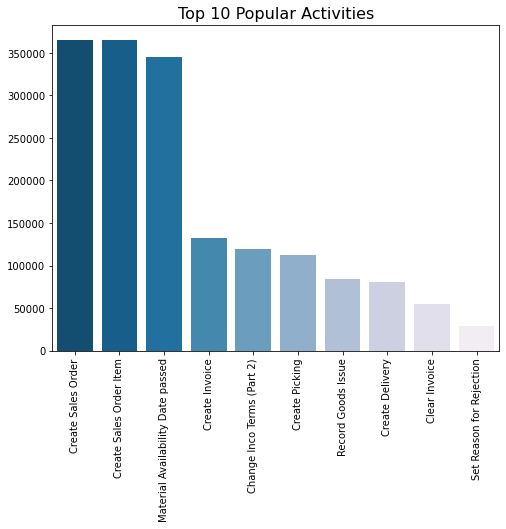

In [12]:
# plotting the most popular activities
plot_df = df['ACTIVITY'].value_counts()[:10]
# show figure:
plt.figure(figsize=(8, 6))
sns.barplot(y = plot_df.values, x = plot_df.index, palette="PuBu_r")
plt.xticks(rotation=90)
plt.title('Top 10 Popular Activities', fontsize=16)
plt.show()

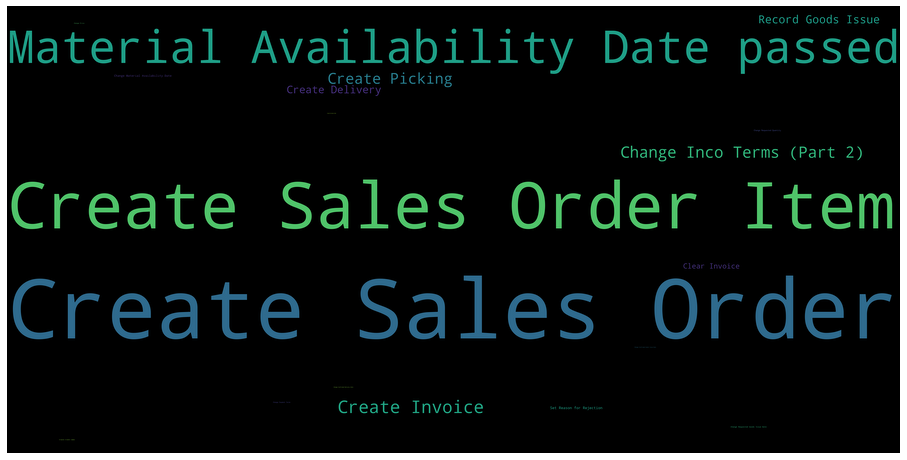

In [13]:
## plotting world cloud based on activity frequencies
# preparing the data
products_tuple_list = [tuple(x) for x in df['ACTIVITY'].value_counts().reset_index().values]
dic = {}
for pair in products_tuple_list:
    key = pair[0]
    value = pair[1]
    if key in dic:
        reservedValue = dic[key]
        reservedValue += value 
    else:
        dic[key] = value
        
# creating the visual
fig = plt.figure(figsize=(16, 12))
wordcloudData = WordCloud(width=4096,height=2048,
                          relative_scaling=1,
                          max_words = 100,
                          max_font_size=500).generate_from_frequencies(frequencies = dic)
plt.imshow(wordcloudData, interpolation='lanczos')
plt.axis("off")
plt.show()

# **3. Data Engineering** <a class="anchor" id="3"></a>

### **3.1. Weight Calculation** <a class="anchor" id="3.1"></a>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1837252 entries, 0 to 1837251
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   ACTIVITY   object
 1   TIMESTAMP  object
 2   COUNTRY    object
 3   CASE_KEY   object
dtypes: object(4)
memory usage: 56.1+ MB


In [15]:
## to obtain the weights of the graph, it is necessary to engineer and make calculation for the time

# changing the date type
df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'], format='%Y-%m-%d %H:%M:%S')

# calculating the time difference after sorting by timestamp and grouping by CASE_KEY
# df['diff'] = df.sort_values('TIMESTAMP', ascending = True).groupby('CASE_KEY')['TIMESTAMP'].diff()

df['diff'] = df.sort_values(['TIMESTAMP', 'ACTIVITY'], ascending = True).groupby('CASE_KEY')['TIMESTAMP'].diff()

In [16]:
# weight_hour: getting the difference in seconds and dividing for 3600 to get the number of hours
# 3600 seconds = 1 hour
df['weight_hour'] = df['diff'].dt.total_seconds() / 3600

In [18]:
df

,ACTIVITY,TIMESTAMP,COUNTRY,CASE_KEY,diff,weight_hour
0,Create Sales Order,2021-10-04 16:22:36,BR,5004324310,0 days 16:22:36,16.376667
1,Create Sales Order Item,2021-10-04 16:22:36,BR,5004324310,0 days 00:00:00,0.000000
2,Material Availability Date passed,2021-10-04 00:00:00,BR,5004324310,NaT,NaN
3,Create Sales Order,2021-10-04 16:22:36,BR,5004324320,0 days 16:22:36,16.376667
4,Create Sales Order Item,2021-10-04 16:22:36,BR,5004324320,0 days 00:00:00,0.000000
...,...,...,...,...,...,...
1837247,Create Sales Order,2022-01-28 14:32:03,BR,1129241623100,NaT,NaN
1837248,Create Sales Order Item,2022-01-28 14:32:03,BR,112924162390,0 days 00:00:00,0.000000
1837249,Create Sales Order,2022-01-28 14:32:03,BR,112924162390,NaT,NaN
1837250,Create Sales Order Item,2022-01-28 14:32:03,BR,112924162380,0 days 00:00:00,0.000000


In [19]:
# dropping unnecessary columns
df.drop(columns=['diff'], inplace = True)

# resetting the index
df = df.sort_values(['CASE_KEY', 'TIMESTAMP', 'ACTIVITY'], ascending = True).reset_index(drop = True)

backup = df.copy()
# df = backup.copy()

### **3.2. Source and Target creation** <a class="anchor" id="3.2"></a>

In [20]:
## creating Source: 
# appending previous activity in subsequent row after aggregation by case_key and sorting by timestamp
source = ['']
for i in range(1, max(df.index)+1):
    source.append(df['ACTIVITY'][i-1])

df['Source'] = source

In [30]:
# filtering the notnull weight_hour (NaN in case it is the first occurence grouped by case_key)
final_log = df[df['weight_hour'].notnull()]

In [31]:
# dropping and renaming columns
final_log = final_log[['Source', 'ACTIVITY', 'weight_hour']]
final_log.columns = ['Source', 'Target', 'weight']

In [39]:
# creating a column to calculate the frequency of the links
final_log['frequency'] = 1

In [41]:
## aggregaating all cases by source and target and calculating median of the aggregation
# Note: chosing median because it is not affected by outliers
final_log = final_log.groupby(['Source', 'Target']).agg({'weight':'median','frequency':'sum'}).reset_index(drop=False)

In [43]:
# keeping the index as edge identifier (combination of 2 linked activities)
final_log.reset_index(inplace = True)
# renaming columns
final_log.columns = ['index', 'source', 'target', 'weight', 'frequency']
final_log.head()

,index,source,target,weight,frequency
0,0,Cancel Goods Issue,Cancel Goods Issue,0.000000,5
1,1,Cancel Goods Issue,Change Payment Terms,0.020139,4
2,2,Cancel Goods Issue,Change Price,0.010000,1
3,3,Cancel Goods Issue,Create Invoice,0.014028,4
4,4,Cancel Goods Issue,Record Goods Issue,0.060833,3343


# **4. Graph Analytics** <a class="anchor" id="4"></a>

In [44]:
# creating a graph with the dataframe engineered
G_dir = nx.from_pandas_edgelist(
    final_log,
    edge_key="index",
    edge_attr=["weight", "frequency"],
    create_using=nx.DiGraph(),
)

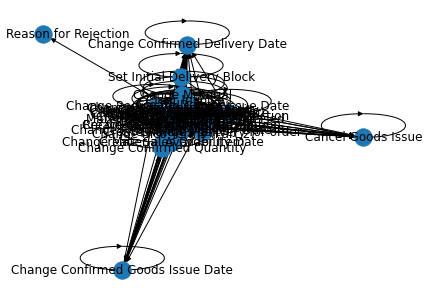

In [26]:
# plotting the graph
nx.draw(G_dir,with_labels = True)

### **4.1. Variant Explorer** <a class="anchor" id="4.1"></a>

In [27]:
df['ACTIVITY'].value_counts()

Create Sales Order                   365032
Create Sales Order Item              365032
Material Availability Date passed    345194
Create Invoice                       132929
Change Inco Terms (Part 2)           119269
Create Picking                       112369
Record Goods Issue                    84433
Create Delivery                       81096
Clear Invoice                         55069
Set Reason for Rejection              28599
Change Material Availability Date     21228
Change Requested Quantity             13996
Change Requested Goods Issue Date     12763
Change Payment Terms                  11662
Change Price                          10224
Create Credit memo                    10142
Change Confirmed Goods Issue Date      8463
Change Confirmed Delivery Date         8283
Create Purchase Order                  6901
Record Return Goods Receipt            5456
Create Returns delivery for order      5357
Change Material                        4019
Customer Acceptance (L650)      

In [28]:
# identifying the closure of the process for the happy path
# Clear invoice frquency: 55069
print( 'Considering the : ',( 55069 / len(df['CASE_KEY'].unique()) ) * 100, ' % of the cases')

Considering the :  15.08607464551053  % of the cases
